## Implimentation of vdsr (2nd paper)

- this paper also uses skip connections to give the output.

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
import os 
from torch.utils.data import Dataset, DataLoader
import os
from math import sqrt
from PIL import Image

In [9]:
def add_images_from_directory(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.png')):  # Add more extensions if needed
            image_path = os.path.join(directory, filename)
            try:
                with Image.open(image_path) as img:
                    images.append(img.copy())  # We use copy() to keep the image in memory after closing the file
            except IOError:
                print(f"Error loading image: {image_path}")
    return images

lr=[]
lr_directory = r'C:\Users\Ankit\Documents\Vedanshi\T_91\T91_LR_unblur'
hr_directory = r'C:\Users\Ankit\Documents\Vedanshi\T_91\T91_HR_unblur'
lr=add_images_from_directory(lr_directory)
hr=add_images_from_directory(hr_directory)
lr_ycbcr=[image.convert('YCbCr') for image in lr]
hr_ycbcr=[image.convert('YCbCr') for image in hr]
lr_y=[np.array(image)[:,:,0] for image in lr_ycbcr]
hr_y=[np.array(image)[:,:,0] for image in hr_ycbcr]

#a class for creating the train and test dataset.
class SRDataset(Dataset):
    def __init__(self, lr_images, hr_images, transform=None):
        self.lr_images = lr_images
        self.hr_images = hr_images
        self.transform = transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image = self.lr_images[idx]
        hr_image = self.hr_images[idx]
        
        # Convert PIL Images to tensors
        to_tensor = transforms.ToTensor()
        lr_tensor = to_tensor(lr_image)
        hr_tensor = to_tensor(hr_image)
        
        if self.transform:
            lr_tensor = self.transform(lr_tensor)
            hr_tensor = self.transform(hr_tensor)
        
        return lr_tensor, hr_tensor
    
#making train and test loaders for the y channels of the images.
train_split = 0.8  # 80% for training, 20% for testing
split_idx = int(len(lr_y) * train_split)

train_lr = lr_y[:split_idx]
train_hr = hr_y[:split_idx]
test_lr = lr_y[split_idx:]
test_hr = hr_y[split_idx:]

# Create datasets
train_dataset = SRDataset(train_lr, train_hr)
test_dataset = SRDataset(test_lr, test_hr)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [10]:
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    max_pixel = torch.max(img1)
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr
def visualize_psnr(inputs, outputs, labels):
    psnr_values = []
    for i in range(len(inputs)):
        psnr_value = psnr(outputs[i], labels[i])
        psnr_values.append(psnr_value.item())
        
    fig, ax = plt.subplots()
    ax.plot(range(len(inputs)), psnr_values, marker='o')
    ax.set_xlabel('Image Index')
    ax.set_ylabel('PSNR')
    ax.set_title('PSNR Metric')
    plt.show()

def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr

In [17]:
def show_images(inputs, outputs, labels):
    fig, axs = plt.subplots(4, 3, figsize=(15, 15))
    for i in range(4):
        input_img = inputs[i].numpy().transpose((1, 2, 0))
        output_img = outputs[i].detach().numpy().squeeze()
        label_img = labels[i].numpy().squeeze()
       
        axs[i, 0].imshow(input_img)
        axs[i, 0].set_title("Low-Res Input")
        axs[i, 0].axis('off')
        axs[i, 1].imshow(output_img, cmap='gray')
        axs[i, 1].set_title("Model Output")
        axs[i, 1].axis('off')
        axs[i, 2].imshow(label_img, cmap='gray')
        axs[i, 2].set_title("Ground Truth")
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

porbable inputs needed are:

1. the low res image 

2. the scale it has to be upscalled to

the output image is the high res version of the original image.

we'll need the coressponding hr iamges only for validation. 

In [12]:

# The class for the intermediate layers of the model.
class Conv(nn.Module):
    def __init__(self, channels, kernel_size=3, stride=1, padding=1):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.conv(x))

# The main class for the model.
class VDSR(nn.Module):
    def __init__(self, input_channels=1, output_channels=64, kernel_size=3, stride=1, padding=1, num_layers=20):
        super(VDSR, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias=False),
            nn.ReLU(inplace=True)
        )
        
        self.residual_layers = nn.Sequential(
            *[Conv(output_channels) for _ in range(num_layers - 2)]
        )
        
        self.conv2 = nn.Conv2d(output_channels, input_channels, kernel_size, stride, padding, bias=False)
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.residual_layers(out)
        out = self.conv2(out)
        out = torch.add(out, identity)
        return out
    
    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight.data, mean=0.0, 
                                std=sqrt(2 / (module.kernel_size[0] * module.kernel_size[1] * module.out_channels)))

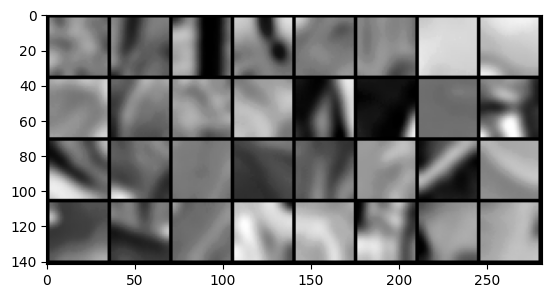

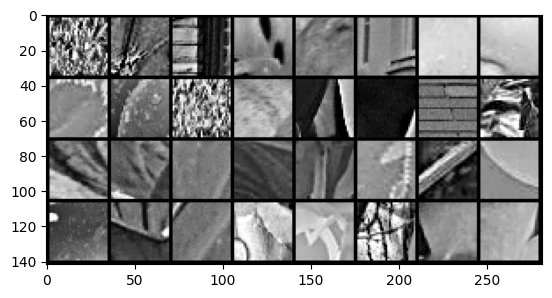

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
imshow(torchvision.utils.make_grid(labels))

# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Weight decay (weight_decay=0.0001) is a form of L2 regularization. The impact would be:

- Helps prevent overfitting by penalizing large weights

- Encourages the model to learn simpler patterns

- The value 0.0001 is a moderate setting, providing some regularization without being too restrictive

[Epoch 0, Batch 0] loss: 0.023, PSNR: 16.34 dB
[Epoch 0, Batch 100] loss: 0.023, PSNR: 16.49 dB
[Epoch 0, Batch 200] loss: 0.022, PSNR: 16.75 dB
[Epoch 0, Batch 300] loss: 0.022, PSNR: 16.64 dB
[Epoch 0, Batch 400] loss: 0.023, PSNR: 16.44 dB
[Epoch 0, Batch 500] loss: 0.023, PSNR: 16.52 dB


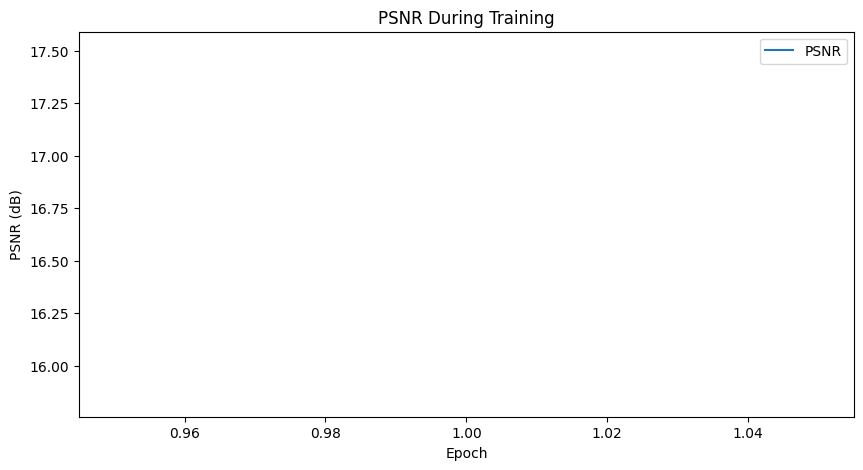

In [14]:
cnn_91 = VDSR()
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_91.parameters(), lr=0.001,weight_decay=0.0001)
num_epochs = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_91 = cnn_91.to(device)
psnr_values = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_psnr = 0.0
    batch_count = 0
    cnn_91.train()  # Set the model to training mode
    for i, (low_res, high_res) in enumerate(train_loader):
        # Move inputs and labels to the same device as the model
        low_res = low_res.to(device)
        high_res = high_res.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = cnn_91(low_res)
        
        # Compute loss
        loss = criterion(outputs, high_res)
        
        # Compute PSNR
        psnr = calculate_psnr(outputs, high_res)
        
        # Backward pass and optimize
        loss.backward()
        nn.utils.clip_grad_norm_(cnn_91.parameters(), 0.4)
        optimizer.step()
        
        
        # Accumulate statistics
        running_loss += loss.item()
        running_psnr += psnr.item()
        batch_count += 1
        
        if i % 100 == 0:  # print every 100 mini-batches
            avg_loss = running_loss / batch_count
            avg_psnr = running_psnr / batch_count
            print(f'[Epoch {epoch }, Batch {i }] loss: {avg_loss:.3f}, PSNR: {avg_psnr:.2f} dB',flush=True)
            running_loss = 0.0
            running_psnr = 0.0
            batch_count = 0

    # Store PSNR value for each epoch
    avg_psnr = running_psnr / batch_count if batch_count > 0 else 0
    psnr_values.append(avg_psnr)

# Plot the PSNR values after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), psnr_values, label='PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('PSNR During Training')
plt.legend()
plt.show()

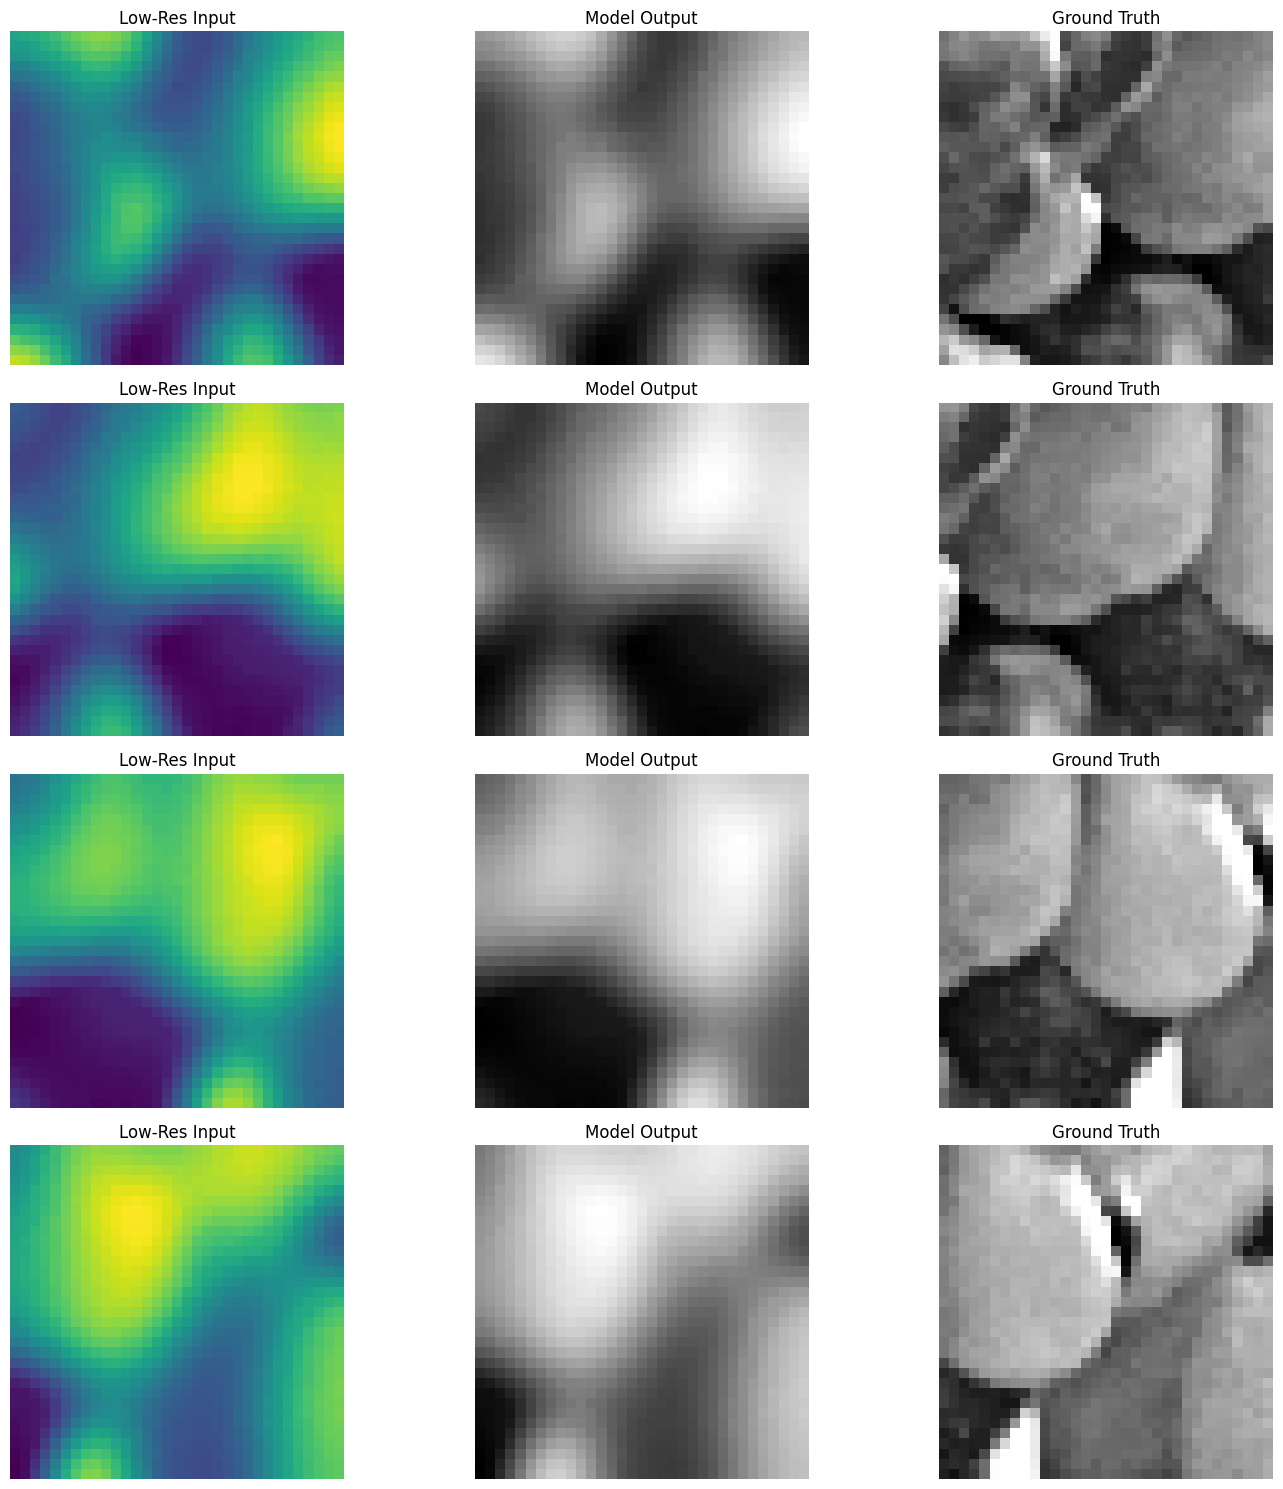

TypeError: visualize_psnr() missing 1 required positional argument: 'labels'

In [18]:
cnn_91.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for i, (low_res, high_res) in enumerate(test_loader):
        # Move inputs and labels to the same device as the model
        low_res = low_res.to(device)
        high_res = high_res.to(device)
        
        # Forward pass
        outputs = cnn_91(low_res)
        
        # Visualize the results for the first batcha
        if i == 0:
            show_images(low_res, outputs, high_res)
            visualize_psnr(outputs, high_res)
            break

## nothing substaintial